In [1]:
pip install scikit-fuzzy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894077 sha256=649252c7ce190ad7bfd4dcd352e32906e9067de51572170500e0a4b433339d96
  Stored in directory: /root/.cache/pip/wheels/4f/86/1b/dfd97134a2c8313e519bcebd95d3fedc7be7944db022094bc8
Successfully built scikit-fuzzy


In [13]:
import pandas as pd
import numpy as np
import skfuzzy as fuzz
import warnings
warnings.filterwarnings('ignore')

# Load your data
students_data = pd.read_csv("summaries_train.csv")  # replace with your actual file path
prompts_data = pd.read_csv("prompts_train.csv")  # replace with your actual file path

# Function to calculate fuzzy raelevance score
def calculate_relevance_score(prompt_text, student_text):
    keyword_frequency = sum(1 for word in prompt_text.split() if word in student_text)


    # Corrected positional_similarity calculation
    positional_similarity = 1 / (1 + sum(abs(prompt_text.find(keyword) - student_text.find(keyword)) for keyword in prompt_text.split()))

    sentence_length = len(student_text.split())

    # Manually define the membership function values
    relevance_points = np.arange(0, 11, 1)
    relevance_values = [0, 1, 0]

    # Fuzzy inference
    relevance = fuzz.interp_membership(relevance_points, relevance_points, relevance_values)

    features = [keyword_frequency, positional_similarity, sentence_length]
    relevance_score = max(features) * relevance

    return relevance_score

# Iterate through each prompt
for prompt_id, prompt_question, prompt_text in prompts_data[['prompt_id', 'prompt_question', 'prompt_text']].values:
    # Filter students who chose the current prompt
    students_for_prompt = students_data[students_data['prompt_id'] == prompt_id]

    # Iterate through each student for the current prompt
    for index, student_row in students_for_prompt.iterrows():
        student_text = student_row['text']

        # Calculate relevance scores for each student's response
        score = calculate_relevance_score(prompt_text, student_text)

        # Fuzzy Logic Adjustment (example, adjust based on your requirements)
        length_ratio = len(student_row['text']) / len(prompt_text)
        keyword_coverage = sum(1 for word in prompt_text.split() if word in student_row['text']) / len(prompt_text.split())

        adjusted_score = (score + length_ratio + keyword_coverage) / 3

        # Add new columns to the DataFrame
        students_data.loc[index, 'adjusted_score'] = adjusted_score.item() if np.isscalar(adjusted_score) else adjusted_score[0]

# Save the modified DataFrame to a new CSV file
students_data.to_csv("students_data_with_scores.csv", index=False)


In [14]:
# Assuming your data is in a CSV file named 'students_data_with_scores.csv'
students_data_with_scores = pd.read_csv('students_data_with_scores.csv')

# Calculate mean and standard deviation of 'adjusted_score'
mean_score = students_data_with_scores['adjusted_score'].mean()
std_dev_score = students_data_with_scores['adjusted_score'].std()

# Z-score normalization for 'adjusted_score'
students_data_with_scores['normalized_score'] = (students_data_with_scores['adjusted_score'] - mean_score) / std_dev_score

# Scale the normalized scores to the range [0, 100]
students_data_with_scores['normalized_score'] = students_data_with_scores['normalized_score'] * 50 + 50

# Clip the normalized scores to a maximum value of 100 and a minimum value of 0
students_data_with_scores['normalized_score'] = students_data_with_scores['normalized_score'].clip(lower=0, upper=100)

# Save the updated dataset to the same CSV file
students_data_with_scores.to_csv('students_data_with_scores.csv', index=False)


In [15]:
dd=pd.read_csv('students_data_with_scores.csv')
dd.describe()
de=dd['normalized_score']

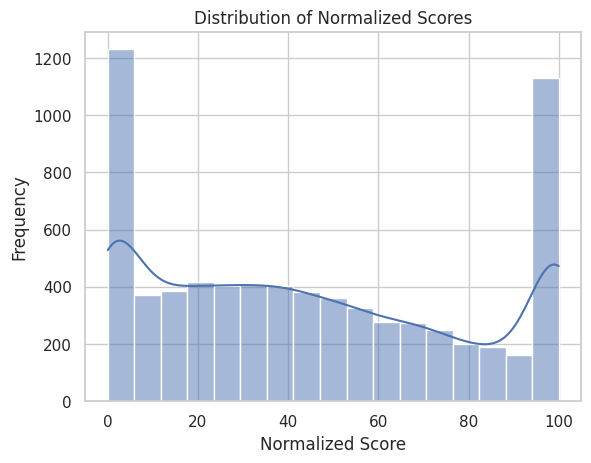

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot a histogram of the 'normalized_score' column
sns.histplot(de, kde=True)
plt.title('Distribution of Normalized Scores')
plt.xlabel('Normalized Score')
plt.ylabel('Frequency')
plt.show()


In [17]:
keyword_frequency = sum(1 for word in prompt_text.split() if word in student_text) / len(student_text.split())

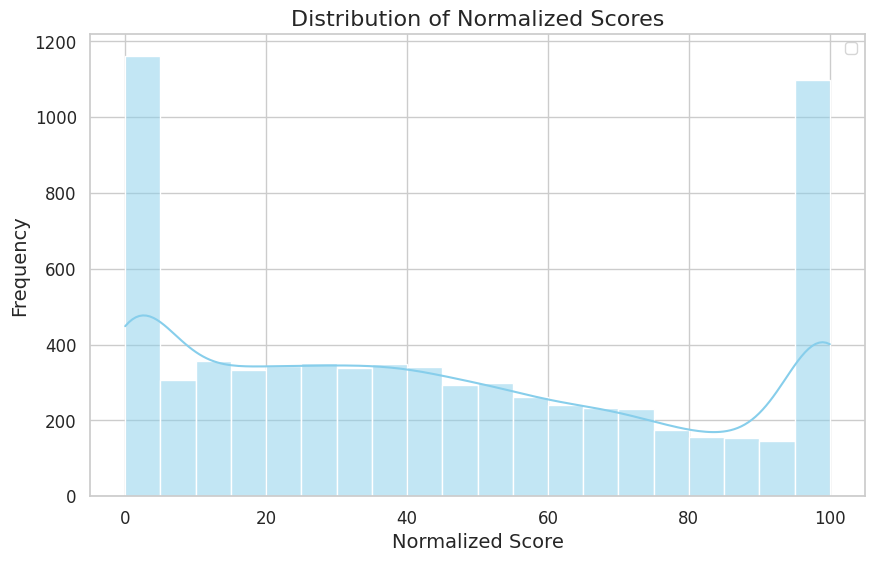

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of seaborn
sns.set(style="whitegrid")

# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot a histogram with a kernel density estimate (KDE)
sns.histplot(dd['normalized_score'], kde=True, color='skyblue', bins=20, ax=ax)

# Customize the appearance
ax.set_title('Distribution of Normalized Scores', fontsize=16)
ax.set_xlabel('Normalized Score', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
ax.tick_params(axis='both', labelsize=12)

# Add legend
ax.legend()

# Show the plot
plt.show()
